AUDU Bastien, PISCIONE Thomas

In [1]:
import numpy as np
np.set_printoptions(threshold=10000,suppress=True)
import pandas as pd
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

## I. Découpage de la base en apprentissage/test

In [2]:
wave = pd.read_csv('Wave.txt', header=None, delim_whitespace=True)
x = wave.iloc[:,:-1]
y = wave.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=0, stratify=y)

## II. Simulation de l’aspect semi-supervisé

In [3]:
# Fonction qui separe
def semi_supervised(xTrain, yTrain, percent):
    x_labelise, x_non_labelise, y_labelise, _ = train_test_split(xTrain, yTrain, test_size=percent, random_state=0)
    return x_labelise, y_labelise, x_non_labelise

In [4]:
x_labelise, y_labelise, x_non_labelise = semi_supervised(x_train, y_train, 0.2)

## III. Sélection de variables semi-supervisée

In [5]:
def score(x_labelise, y_labelise, x_non_labelise, variable):
    s1_haut = 0
    s1_bas = 0
    nb_classes = len(np.unique(y_labelise))
    for classe in range(0, nb_classes):
        u_i = np.array(np.mean(x_labelise[y_labelise == classe], axis=0))[variable]
        u = np.mean(x_labelise, axis=0)[variable]
        ecart_type_classes = np.std(x_labelise[y_labelise == classe], axis=0)[variable]
        effectif_classe = len(x_labelise[y_labelise == classe])
        s1_haut += effectif_classe*(u_i - u)**2
        s1_bas += effectif_classe*ecart_type_classes**2
    s1=s1_haut/s1_bas
    variance_variable = np.var(x_non_labelise[variable])
    s2_haut = 0
    for i in range(0, len(x_non_labelise[variable])):
        for j in range(0, len(x_non_labelise[variable])):
            gauche = (x_non_labelise[variable][i] - x_non_labelise[variable][j])**2
            distance = np.linalg.norm(x_non_labelise[i] - x_non_labelise[j])**2
            droite = distance/ 10
            droite = np.exp(-droite)
            s2_haut += gauche*droite
    s2 = s2_haut/variance_variable
    return s1/s2

In [6]:
score(x_labelise, y_labelise, np.array(x_non_labelise), 1)
scores = []
for i in range(0, len(x_non_labelise.columns)):
    scores.append(score(x_labelise, y_labelise, np.array(x_non_labelise), i))
for i in range(0, len(scores)):
    print("Variable " + str(i) + " : " + str(scores[i]))

Variable 0 : 0.00024680990549610807
Variable 1 : 0.02493680155771171
Variable 2 : 0.11598461051356031
Variable 3 : 0.2085035304400286
Variable 4 : 0.42807425965368795
Variable 5 : 0.4239227687392061
Variable 6 : 0.46232697415833457
Variable 7 : 0.352648827183071
Variable 8 : 0.3331002531308382
Variable 9 : 0.32454219674915386
Variable 10 : 0.3330371826819956
Variable 11 : 0.26456986004537814
Variable 12 : 0.3997284304945566
Variable 13 : 0.3827506944601143
Variable 14 : 0.5444430576302739
Variable 15 : 0.4200174164466268
Variable 16 : 0.3196741719801003
Variable 17 : 0.21829270882072663
Variable 18 : 0.10232527174615495
Variable 19 : 0.03390665519145645
Variable 20 : 0.00014112420670457063
Variable 21 : 0.00023324632551580623
Variable 22 : 0.0006606066289633591
Variable 23 : 0.0006077307200210969
Variable 24 : 0.00021817803743798923
Variable 25 : 7.770927564299062e-05
Variable 26 : 0.0010163478441984437
Variable 27 : 0.001721145297258869
Variable 28 : 0.000483370826829119
Variable 29 :

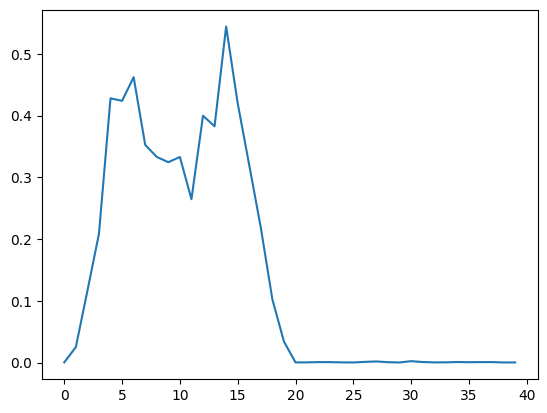

In [7]:
#Plot the scores
plt.plot(scores)

#Index des variables par ordre decroissant de score
variablesTries = np.argsort(scores)[::-1]

Les variables avec le taux le plus haut sont celles qui sont le plus utiles.
On va donc trier les variables par ordre décroissant de score et entrainer un MLP avec les 5 premières, puis les 10, puis les 15, etc.
D'apres ce que l'on voit, l'accuracy devrait monter jusqu'a la 20eme variable, puis se stabiliser.

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
acc = []
#Liste avec les 5 premieres variables, puis les 10
liste = [variablesTries[:5], variablesTries[:10], variablesTries[:15], variablesTries[:20], variablesTries[:25], variablesTries[:30], variablesTries[:35], variablesTries[:40]]
for colonnes in liste:
    print("Variables : " + str(colonnes))
    x_c_train = x_train.iloc[:, colonnes]
    model = MLPClassifier(alpha=0.01)
    model.fit(x_c_train, y_train)
    predict = model.predict(x_test.iloc[:, colonnes])
    acc.append(accuracy_score(y_test, predict))
acc

Variables : [14  6  4  5 15]
Variables : [14  6  4  5 15 12 13  7  8 10]
Variables : [14  6  4  5 15 12 13  7  8 10  9 16 11 17  3]
Variables : [14  6  4  5 15 12 13  7  8 10  9 16 11 17  3  2 18 19  1 30]
Variables : [14  6  4  5 15 12 13  7  8 10  9 16 11 17  3  2 18 19  1 30 27 26 34 31
 37]
Variables : [14  6  4  5 15 12 13  7  8 10  9 16 11 17  3  2 18 19  1 30 27 26 34 31
 37 22 36 23 28 35]
Variables : [14  6  4  5 15 12 13  7  8 10  9 16 11 17  3  2 18 19  1 30 27 26 34 31
 37 22 36 23 28 35 33  0 21 24 32]
Variables : [14  6  4  5 15 12 13  7  8 10  9 16 11 17  3  2 18 19  1 30 27 26 34 31
 37 22 36 23 28 35 33  0 21 24 32 20 39 25 38 29]


[0.7432, 0.8328, 0.8632, 0.8456, 0.8404, 0.842, 0.8332, 0.8332]

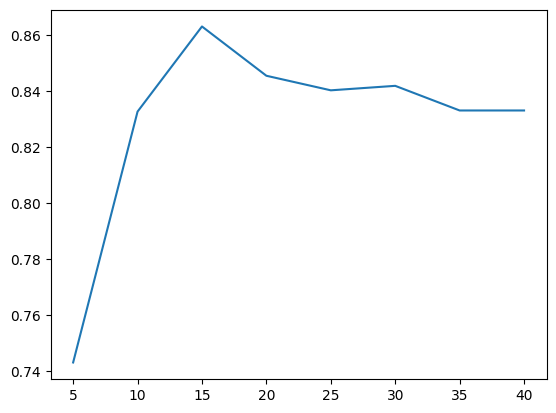

In [9]:
plt.plot([5, 10, 15, 20, 25, 30, 35, 40], acc)

Comme on pouvait s'y attendre, l'accuracy augmente jusqu'a la 20eme variable, puis se stabilise.
Il n'est donc pas necessaire d'utiliser toutes les variables pour obtenir une bonne accuracy.